# Modelo de regressão para prever popularidade de uma música no Spotify
## Dados de 30000 músicas dos gêneros (EDM, Latin, Pop, R&B, Rap, & Rock)

In [6]:
import pickle
import pathlib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [43]:
DATA_DIR = pathlib.Path("C:/Users/gpime/Downloads/trab_final_ML")
print(DATA_DIR)

C:\Users\gpime\Downloads\trab_final_ML


In [8]:
data = pd.read_csv(DATA_DIR / "spotify_songs.csv")

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32833 entries, 0 to 32832
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   track_id                  32833 non-null  object 
 1   track_name                32828 non-null  object 
 2   track_artist              32828 non-null  object 
 3   track_popularity          32833 non-null  int64  
 4   track_album_id            32833 non-null  object 
 5   track_album_name          32828 non-null  object 
 6   track_album_release_date  32833 non-null  object 
 7   playlist_name             32833 non-null  object 
 8   playlist_id               32833 non-null  object 
 9   playlist_genre            32833 non-null  object 
 10  playlist_subgenre         32833 non-null  object 
 11  danceability              32833 non-null  float64
 12  energy                    32833 non-null  float64
 13  key                       32833 non-null  int64  
 14  loudne

In [10]:
model_data = data.copy()

In [11]:
categorical_variables = ['playlist_genre', 'playlist_subgenre']

In [12]:
def plot_categoricals(data, cols, sorted=True):
    summary = data[cols] \
        .describe() \
        .transpose() \
        .sort_values(by='count')

    print(summary)

    for col, val in summary['count'].items():
        plt.figure()
        ser = data[col].value_counts()
        if sorted:
            ser = ser.sort_values(ascending=True)
        else:
            ser = ser.sort_index()
        ax = ser.plot.barh()

        # Add text annotations manually
        for index, value in enumerate(ser):
            plt.text(value, index, str(value))

        plt.title(f'{col}, n={int(val)}')
        plt.show()

                   count unique                        top  freq
playlist_genre     32833      6                        edm  6043
playlist_subgenre  32833     24  progressive electro house  1809


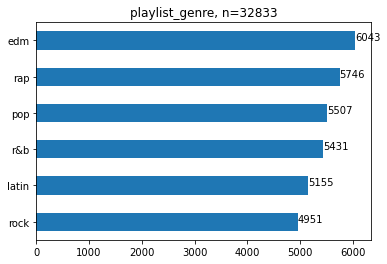

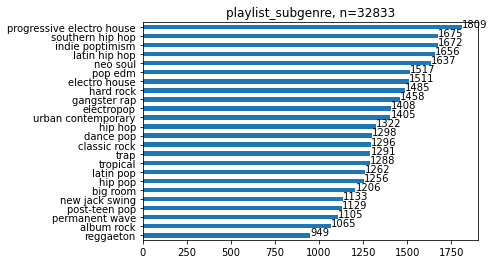

In [13]:
plot_categoricals(model_data, categorical_variables)

***Categorical variables seem fine and already ready to be used in the regression***

***Removing all columns which won't be used in the model***

In [14]:
columns_to_remove = [0, 1, 2, 4, 5, 7, 8]
column_names_to_remove = [model_data.columns[i] for i in columns_to_remove]


model_data = model_data.drop(column_names_to_remove, axis=1)

model_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32833 entries, 0 to 32832
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   track_popularity          32833 non-null  int64  
 1   track_album_release_date  32833 non-null  object 
 2   playlist_genre            32833 non-null  object 
 3   playlist_subgenre         32833 non-null  object 
 4   danceability              32833 non-null  float64
 5   energy                    32833 non-null  float64
 6   key                       32833 non-null  int64  
 7   loudness                  32833 non-null  float64
 8   mode                      32833 non-null  int64  
 9   speechiness               32833 non-null  float64
 10  acousticness              32833 non-null  float64
 11  instrumentalness          32833 non-null  float64
 12  liveness                  32833 non-null  float64
 13  valence                   32833 non-null  float64
 14  tempo 

In [15]:
unique_album_release_dates = model_data['track_album_release_date'].nunique()
print(f"Number of unique album release dates: {unique_album_release_dates}")

Number of unique album release dates: 4530


In [16]:
model_data['track_album_release_date']

0        2019-06-14
1        2019-12-13
2        2019-07-05
3        2019-07-19
4        2019-03-05
            ...    
32828    2014-04-28
32829    2013-03-08
32830    2014-04-21
32831    2014-01-01
32832    2014-03-03
Name: track_album_release_date, Length: 32833, dtype: object

***feature engineering the date columns so it represents how old the song is***

In [17]:
def calculate_day_difference(df, date_column):
    df[date_column] = pd.to_datetime(df[date_column])
    most_recent_date = df[date_column].max()
    df['days_from_most_recent'] = (most_recent_date - df[date_column]).dt.days
    df = df.drop(columns=[date_column])  # Drop the original date column
    return df

model_data = model_data.pipe(calculate_day_difference, 'track_album_release_date')

print(model_data)

       track_popularity playlist_genre          playlist_subgenre  \
0                    66            pop                  dance pop   
1                    67            pop                  dance pop   
2                    70            pop                  dance pop   
3                    60            pop                  dance pop   
4                    69            pop                  dance pop   
...                 ...            ...                        ...   
32828                42            edm  progressive electro house   
32829                20            edm  progressive electro house   
32830                14            edm  progressive electro house   
32831                15            edm  progressive electro house   
32832                27            edm  progressive electro house   

       danceability  energy  key  loudness  mode  speechiness  acousticness  \
0             0.748   0.916    6    -2.634     1       0.0583      0.102000   
1            

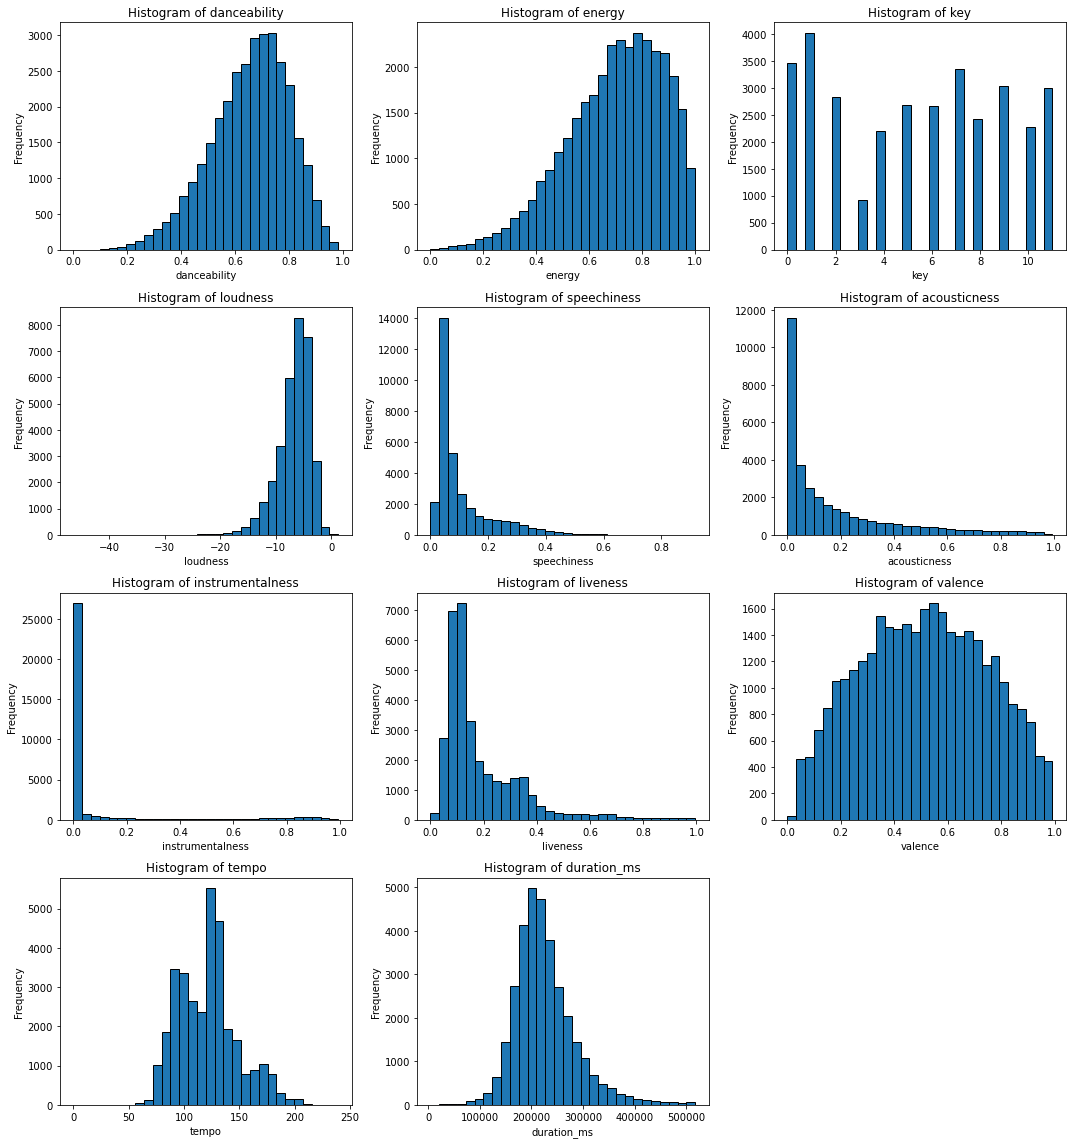

In [18]:
def plot_histograms(data, columns):
    num_plots = len(columns)
    num_rows = (num_plots // 3) + (num_plots % 3 > 0) 
    
    plt.figure(figsize=(15, 4 * num_rows))
    
    for i, column in enumerate(columns, 1):
        plt.subplot(num_rows, 3, i)
        plt.hist(data[column], bins=30, edgecolor='k')
        plt.title(f'Histogram of {column}')
        plt.xlabel(column)
        plt.ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()

numeric_columns = [
    'danceability', 'energy', 'key', 'loudness',
    'speechiness', 'acousticness', 'instrumentalness',
    'liveness', 'valence', 'tempo', 'duration_ms'
]

plot_histograms(model_data, numeric_columns)

***Creating dummies that describe if a musica is vocal dominant or more intrumental by tone***

In [19]:
def create_dummies(df):

    df['is_instrumental'] = (df['instrumentalness'] > 0).astype(int)
    
    df['vocal_minor'] = ((df['is_instrumental'] == 0) & (df['mode'] == 0)).astype(int)
    df['vocal_major'] = ((df['is_instrumental'] == 0) & (df['mode'] == 1)).astype(int)

    df['instrumental_major'] = ((df['is_instrumental'] == 1) & (df['mode'] == 1)).astype(int)

    df.drop(['instrumentalness', 'mode', 'is_instrumental','key'], axis=1, inplace=True)
    
    return df

model_data = create_dummies(model_data)

***Turning categorical variables into dummies***

In [20]:
model_data = pd.get_dummies(model_data, columns=['playlist_genre', 'playlist_subgenre'], drop_first=True)

In [21]:
model_data

,track_popularity,danceability,energy,loudness,speechiness,acousticness,liveness,valence,tempo,duration_ms,...,playlist_subgenre_new jack swing,playlist_subgenre_permanent wave,playlist_subgenre_pop edm,playlist_subgenre_post-teen pop,playlist_subgenre_progressive electro house,playlist_subgenre_reggaeton,playlist_subgenre_southern hip hop,playlist_subgenre_trap,playlist_subgenre_tropical,playlist_subgenre_urban contemporary
0,66,0.748,0.916,-2.634,0.0583,0.102000,0.0653,0.5180,122.036,194754,...,0,0,0,0,0,0,0,0,0,0
1,67,0.726,0.815,-4.969,0.0373,0.072400,0.3570,0.6930,99.972,162600,...,0,0,0,0,0,0,0,0,0,0
2,70,0.675,0.931,-3.432,0.0742,0.079400,0.1100,0.6130,124.008,176616,...,0,0,0,0,0,0,0,0,0,0
3,60,0.718,0.930,-3.778,0.1020,0.028700,0.2040,0.2770,121.956,169093,...,0,0,0,0,0,0,0,0,0,0
4,69,0.650,0.833,-4.672,0.0359,0.080300,0.0833,0.7250,123.976,189052,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32828,42,0.428,0.922,-1.814,0.0936,0.076600,0.0668,0.2100,128.170,204375,...,0,0,0,0,1,0,0,0,0,0
32829,20,0.522,0.786,-4.462,0.0420,0.001710,0.3750,0.4000,128.041,353120,...,0,0,0,0,1,0,0,0,0,0
32830,14,0.529,0.821,-4.899,0.0481,0.108000,0.1500,0.4360,127.989,210112,...,0,0,0,0,1,0,0,0,0,0
32831,15,0.626,0.888,-3.361,0.1090,0.007920,0.3430,0.3080,128.008,367432,...,0,0,0,0,1,0,0,0,0,0


## Train-test splitting

In [22]:
X = model_data.drop(columns=['track_popularity']).copy()
y = model_data['track_popularity'].copy()

In [23]:
X.values, y.values

(array([[ 0.748,  0.916, -2.634, ...,  0.   ,  0.   ,  0.   ],
        [ 0.726,  0.815, -4.969, ...,  0.   ,  0.   ,  0.   ],
        [ 0.675,  0.931, -3.432, ...,  0.   ,  0.   ,  0.   ],
        ...,
        [ 0.529,  0.821, -4.899, ...,  0.   ,  0.   ,  0.   ],
        [ 0.626,  0.888, -3.361, ...,  0.   ,  0.   ,  0.   ],
        [ 0.603,  0.884, -4.571, ...,  0.   ,  0.   ,  0.   ]]),
 array([66, 67, 70, ..., 14, 15, 27], dtype=int64))

In [24]:
from sklearn.model_selection import train_test_split

C:\ProgramData\Anaconda3\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [25]:
RANDOM_SEED = 42 

In [26]:
Xtrain, Xtest, ytrain, ytest = train_test_split(
    X,
    y,
    test_size=0.25,
    random_state=RANDOM_SEED,
)


In [27]:
X.shape, Xtrain.shape, Xtest.shape

((32833, 41), (24624, 41), (8209, 41))

In [28]:
y.shape, ytrain.shape, ytest.shape

((32833,), (24624,), (8209,))

## Fitting a linear model

In [29]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from timeit import default_timer

***First, let's estimate a Random Forest model. For the selection of hyperparameters, we will use a grid search, and afterwards, we'll compare the model to other models using cross-validation.***

In [31]:
grid_search = GridSearchCV(
    RandomForestRegressor(n_estimators=100, random_state=RANDOM_SEED, n_jobs=-1),
    {'n_estimators': [100, 200, 300]},
    cv=4, 
    n_jobs=-1, 
    scoring='neg_mean_squared_error', 
    return_train_score=True
)

t1 = default_timer()
grid_search.fit(Xtrain, ytrain)
t2 = default_timer()
print(f'Tempo gasto: {t2 - t1:.2f} s')

Tempo gasto: 187.40 s


In [32]:
forest_reg = grid_search.best_estimator_

from sklearn.model_selection import cross_val_score

t1 = default_timer()
forest_reg_scores = cross_val_score(forest_reg, Xtrain, ytrain, 
                                    scoring="neg_mean_squared_error", cv=8, n_jobs=-1)
t2 = default_timer()
print(f'Tempo gasto: {t2 - t1:.2f} s')

forest_reg_rmse_scores = np.sqrt(-forest_reg_scores)
print(forest_reg_rmse_scores)

Tempo gasto: 161.37 s
[20.90594654 20.62721345 20.78941366 20.49773492 20.76007277 20.47486655
 20.6038741  20.32791489]


***Now, let's estimate a decision tree model also using grid search to select the best hyperparameters.***

In [36]:

param_grid = [
   {'min_samples_leaf': [2, 4, 6, 8], 'splitter': ['best', 'random'],
     'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 6, 10],
     'max_features': [None, 'sqrt', 'log2']},
  ]

tree_reg = DecisionTreeRegressor(random_state=RANDOM_SEED)

grid_search = GridSearchCV(tree_reg, param_grid, cv=6, scoring='neg_mean_squared_error', return_train_score=True, n_jobs=-1)

grid_search.fit(Xtrain, ytrain)

tree_reg = grid_search.best_estimator_

from sklearn.model_selection import cross_val_score

t1 = default_timer()
tree_reg_scores = cross_val_score(tree_reg, Xtrain, ytrain, 
                                    scoring="neg_mean_squared_error", cv=8, n_jobs=-1)
t2 = default_timer()
print(f'Tempo gasto: {t2 - t1:.2f} s')

tree_reg_rmse_scores = np.sqrt(-tree_reg_scores)
print(tree_reg_rmse_scores)

Tempo gasto: 0.95 s
[23.42203803 22.8161549  23.32874777 22.51479311 23.31923883 23.08628913
 23.20029412 22.83798958]


***Linear regression is a simple model with few hyperparameters, and in its basic form, it doesn't have parameters to adjust. Additionally, it is less prone to overfitting due to its simplicity, making complex regularization methods less necessary. Moreover, given the sample size, it was not necessary to use methods that require the selection of additional hyperparameters.***

In [37]:
lin_reg = LinearRegression()

t1 = default_timer()
lin_reg_scores = cross_val_score(lin_reg, Xtrain, ytrain, 
                                 scoring="neg_mean_squared_error", cv=8, n_jobs=-1)
t2 = default_timer()
print(f'Tempo gasto: {t2 - t1:.2f} s')

lin_reg_rmse_scores = np.sqrt(-lin_reg_scores)
print(lin_reg_rmse_scores)

Tempo gasto: 0.56 s
[23.14503734 22.71535926 23.22678829 22.76254383 23.13049501 22.83312781
 23.33466826 22.49950571]


***Finally, we compared the performance of the three models.***

In [38]:
from scipy.stats import mannwhitneyu

# Random Forest versus Decision Tree.
U, pvalue = mannwhitneyu(forest_reg_rmse_scores, tree_reg_rmse_scores)
print("p-value Random Forest versus Decision Tree: {}".format(pvalue))

# Random Forest versus Linear Regressor.
U, pvalue = mannwhitneyu(forest_reg_rmse_scores, lin_reg_rmse_scores)
print("p-value Random Forest versus Linear Regressor: {}".format(pvalue))

# Decision Tree versus Linear Regressor.
U, pvalue = mannwhitneyu(tree_reg_rmse_scores, lin_reg_rmse_scores)
print("p-value Decision Tree versus Linear Regressor: {}".format(pvalue))

p-value Random Forest versus Decision Tree: 0.00046955284955859495
p-value Random Forest versus Linear Regressor: 0.00046955284955859495
p-value Decision Tree versus Linear Regressor: 0.21544852186813368


***In other words, at usual levels of significance, there is evidence that the Random Forest model, for this dataset, has a higher predictive performance.***

## Final avaliation of performance

In [39]:
forest_reg.fit(Xtrain, ytrain)
y_pred = forest_reg.predict(Xtest)

print(np.sqrt(mean_squared_error(ytest, y_pred)))

20.67197930555532


***The chosen model has a square root of mean squared error of ~20.67***

# Final training

In [40]:
forest_reg.fit(X, y)

RandomForestRegressor(n_estimators=300, n_jobs=-1, random_state=42)

In [41]:
import joblib
from joblib import dump

In [45]:
model_filepath = DATA_DIR / 'forest_reg_trab_final.joblib'

dump(forest_reg, model_filepath)

['C:\\Users\\gpime\\Downloads\\trab_final_ML\\forest_reg_trab_final.joblib']